In [4]:
import re
import pandas as pd
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span

beyonce_df = pd.read_csv('/Users/mertakcay/Projects/Knowledge Graphs/Neo4j/context.csv')
context_list = beyonce_df['context'].apply(lambda x : re.sub(r'[^\w\s]', '', x))

In [2]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [3]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [8]:
entities_list, relation_list = list(), list()
for context in context_list:
    entities_list.append(get_entities(context))
    relation_list.append(get_relation(context))

In [10]:
entities_list

[['2003 Beyoncés debut which', 'Crazy numberone Love'],
 ['fifth studio album Beyoncé', 'experimental  darker'],
 ['2014 Forbes magazine', 'female  2015'],
 ['Performing High School Beyoncé', 'two United Methodist years'],
 ['shortly  group', 'Columbia Records'],
 ['original Boyz II All', '1999  film'],
 ['Franklin', 'just Beyoncé Rowland'],
 ['hiatus', 'solo  careers'],
 ['also Beyoncés Summertime', 'better US charts'],
 ['2 Best RB I', 'Luther Vandross'],
 ['American  group', '2005 Hollywood March'],
 ['other United Me', 'United Kingdom'],
 ['2007 soundtrack Beyoncé', 'additional Shakira Beautiful Liar'],
 ['I', '108 1195 million'],
 ['negative  movie', '2010 Best Fight'],
 ['airplay Mariah chart', 'Best Pop Vocals'],
 ['European Great Wall', 'Egyptian English music festivals'],
 ['year Bush Haiti she', 'highestpaid Glastonbury minute'],
 ['Intimate Yorks Roseland Nights', 'standing Beyoncé room'],
 ['later New she', 'first Blue Ivy'],
 ['global WarnerChappell which', 'songwriting st

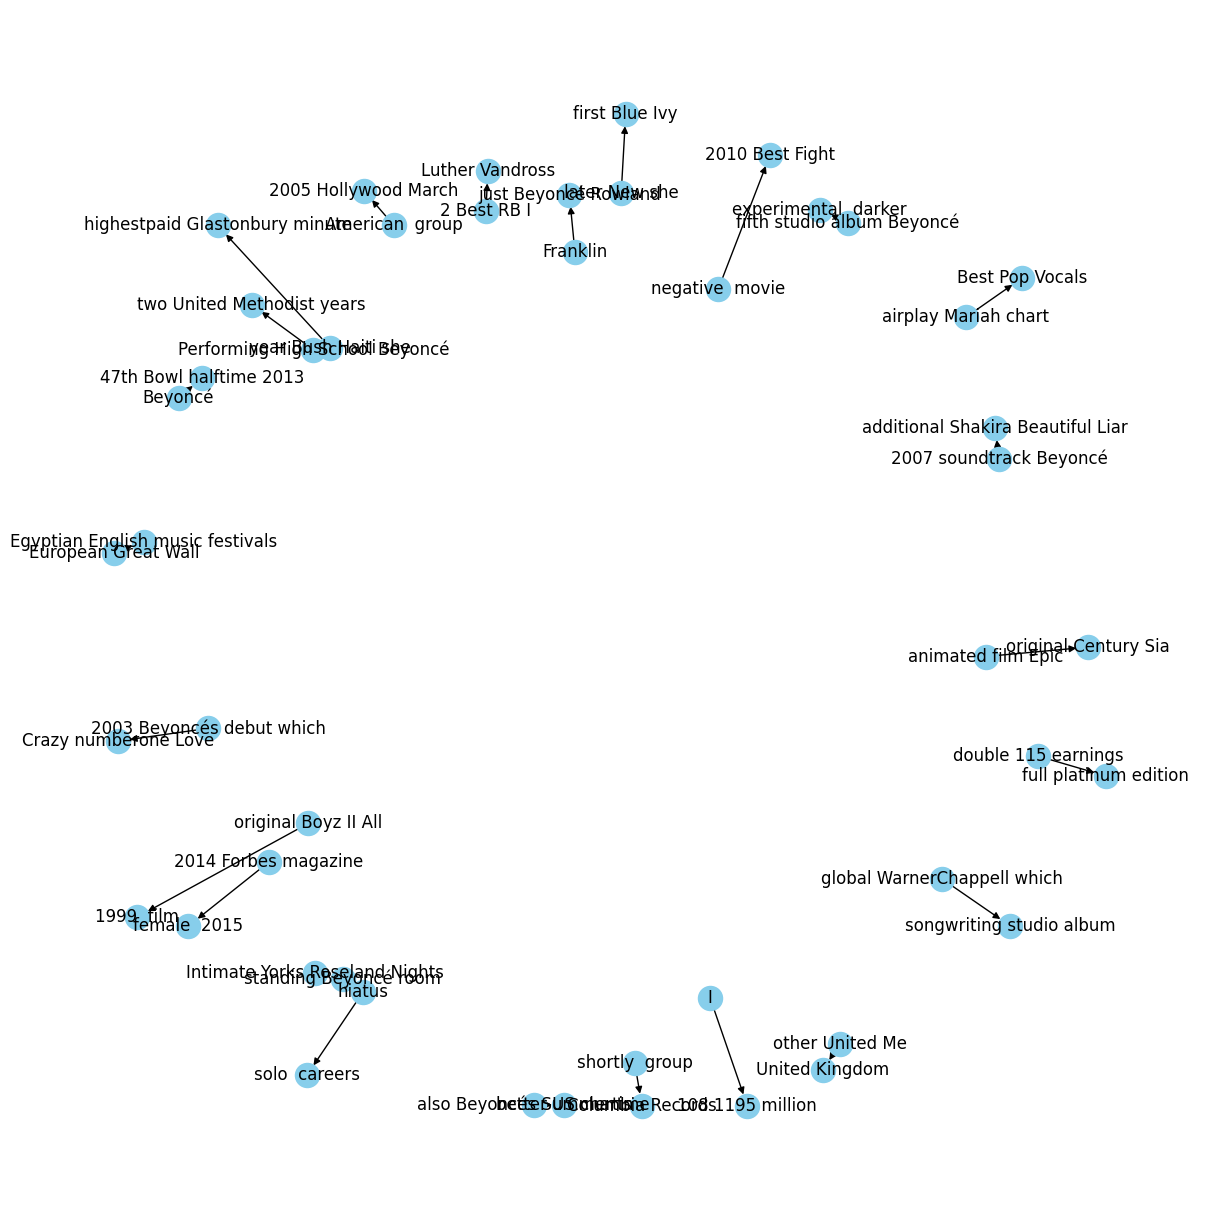

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
# extract subject
source = [i[0] for i in entities_list]

# extract object
target = [i[1] for i in entities_list]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relation_list})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()